## 1. Carga de librerías

In [18]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


## 2. Carga de datasets

In [19]:
df_pm10 = pd.read_csv(
    '../data/raw/pm 10 coyhaique (extended).csv',
    sep=';',
    encoding='latin1',
    engine='python'
)

df_pm25 = pd.read_csv(
    '../data/raw/pm 2.5 coyhaique.csv',
    sep=';'
)

df_co = pd.read_csv(
    '../data/raw/CO coyhaique.csv',
    sep=';'
)

df_so2 = pd.read_csv(
    '../data/raw/SO2 coyahique.csv',
    sep=';'
)

df_meteo = pd.read_csv(
    '../data/raw/export (extended).csv'
)

print("Data loaded successfully.")

Data loaded successfully.


## 3. Limpieza de datos y tratamiento de valores nulos

In [20]:
# Procesar df_pm10
df_pm10 = df_pm10.drop(columns=['Unnamed: 5', 'Registros preliminares', 'Registros no validados'], errors='ignore')
df_pm10['FECHA_HORA'] = pd.to_datetime(df_pm10['FECHA (YYMMDD)'].astype(str) + df_pm10['HORA (HHMM)'].astype(str).str.zfill(4), format='%y%m%d%H%M')
df_pm10 = df_pm10.set_index('FECHA_HORA')

# Calcular valores nulos por día e identificar días completos con valores nulos
df_pm10_nulls = df_pm10[df_pm10['Registros validados'].isnull()]
nulos_por_dia_pm10 = df_pm10_nulls.groupby(df_pm10_nulls.index.date).size()
dias_completos_nulos_pm10 = nulos_por_dia_pm10[nulos_por_dia_pm10 == 24].index.tolist() # Convertir índice a lista

# Filtrar los días completos nulos usando una máscara booleana
mask = [date not in dias_completos_nulos_pm10 for date in df_pm10.index.date]
df_pm10 = df_pm10[mask]

# Imputar los valores nulos restantes
df_pm10['Registros validados'] = df_pm10['Registros validados'].interpolate(method='time')

# Renombrar columna
df_pm10 = df_pm10.rename(columns={'Registros validados': 'PM10'})

# Imprimir confirmación
print("df_pm10 procesado:")
print("Nulos restantes en PM10:", df_pm10['PM10'].isnull().sum())
print("Cantidad total de registros:", df_pm10.shape[0])
print("Rango de fechas:", df_pm10.index.min(), "→", df_pm10.index.max())

df_pm10 procesado:
Nulos restantes en PM10: 0
Cantidad total de registros: 17423
Rango de fechas: 2023-01-02 01:00:00 → 2024-12-31 23:00:00


In [21]:
# Procesar df_pm25
df_pm25 = df_pm25.drop(columns=['Registros preliminares', 'Registros no validados', 'Unnamed: 5'], errors='ignore')
df_pm25['FECHA_HORA'] = pd.to_datetime(
    df_pm25['FECHA (YYMMDD)'].astype(str) + df_pm25['HORA (HHMM)'].astype(str).str.zfill(4),
    format='%y%m%d%H%M'
)
df_pm25 = df_pm25.set_index('FECHA_HORA')

# Calcular nulos por día e identificar días completos con nulos
df_pm25_nulls = df_pm25[df_pm25['Registros validados'].isnull()]
nulos_por_dia_pm25 = df_pm25_nulls.groupby(df_pm25_nulls.index.date).size()
dias_completos_nulos_pm25 = nulos_por_dia_pm25[nulos_por_dia_pm25 == 24].index.tolist()

# Filtrar los días completos con nulos
mask_pm25 = [date not in dias_completos_nulos_pm25 for date in df_pm25.index.date]
df_pm25 = df_pm25[mask_pm25]

# Imputar los nulos restantes
df_pm25['Registros validados'] = df_pm25['Registros validados'].interpolate(method='time')

# Renombrar columna
df_pm25 = df_pm25.rename(columns={'Registros validados': 'PM2.5'})

# Imprimir confirmación
print("df_pm25 procesado:")
print("Nulos restantes en PM2.5:", df_pm25['PM2.5'].isnull().sum())

df_pm25 procesado:
Nulos restantes en PM2.5: 0


In [22]:
# Procesar df_co
df_co = df_co.drop(columns=['Registros preliminares', 'Registros no validados', 'Unnamed: 5'], errors='ignore')

# Reemplazar coma decimal por punto y convertir a float, forzando errores
df_co['Registros validados'] = df_co['Registros validados'].str.replace(',', '.').astype(float)

# Crear columna FECHA_HORA y establecerla como índice
df_co['FECHA_HORA'] = pd.to_datetime(
    df_co['FECHA (YYMMDD)'].astype(str) + df_co['HORA (HHMM)'].astype(str).str.zfill(4),
    format='%y%m%d%H%M'
)
df_co = df_co.set_index('FECHA_HORA')

# Calcular nulos por día e identificar días completos con nulos
df_co_nulls = df_co[df_co['Registros validados'].isnull()]
nulos_dia_co = df_co_nulls.groupby(df_co_nulls.index.date).size()
dias_completos_co = nulos_dia_co[nulos_dia_co == 24].index.tolist()

# Filtrar días completos con nulos
mask_co = [date not in dias_completos_co for date in df_co.index.date]
df_co = df_co[mask_co]

# Interpolar nulos restantes
df_co['Registros validados'] = df_co['Registros validados'].interpolate(method='time')

# Renombrar para integración
df_co = df_co.rename(columns={'Registros validados': 'CO'})

# Confirmación
print("df_co procesado:")
print("Nulos restantes en CO:", df_co['CO'].isnull().sum())

df_co procesado:
Nulos restantes en CO: 0


In [23]:
# Procesar df_so2
df_so2 = df_so2.drop(columns=['Registros preliminares', 'Registros no validados', 'Unnamed: 5'], errors='ignore')

# Convertir a numérico, forzando errores
df_so2['Registros validados'] = pd.to_numeric(df_so2['Registros validados'], errors='coerce')

# Crear columna FECHA_HORA y establecerla como índice
df_so2['FECHA_HORA'] = pd.to_datetime(
    df_so2['FECHA (YYMMDD)'].astype(str) + df_so2['HORA (HHMM)'].astype(str).str.zfill(4),
    format='%y%m%d%H%M'
)
df_so2 = df_so2.set_index('FECHA_HORA')

# Calcular nulos por día e identificar días completos con nulos
df_so2_nulls = df_so2[df_so2['Registros validados'].isnull()]
nulos_dia_so2 = df_so2_nulls.groupby(df_so2_nulls.index.date).size()
dias_completos_so2 = nulos_dia_so2[nulos_dia_so2 == 24].index.tolist()

# Filtrar días completos con nulos
mask_so2 = [date not in dias_completos_so2 for date in df_so2.index.date]
df_so2 = df_so2[mask_so2]

# Interpolar nulos restantes
df_so2['Registros validados'] = df_so2['Registros validados'].interpolate(method='time')

# Renombrar para integración
df_so2 = df_so2.rename(columns={'Registros validados': 'SO2'})

# Confirmación
print("df_so2 procesado:")
print("Nulos restantes en SO2:", df_so2['SO2'].isnull().sum())

df_so2 procesado:
Nulos restantes en SO2: 0


In [24]:
# Procesar df_meteo
# Asegurarse de que la columna 'date' sea de tipo datetime.
df_meteo['date'] = pd.to_datetime(df_meteo['date'])

# Seleccionar solo las columnas relevantes: 'date', 'tmin', 'tavg', 'tmax', 'prcp', 'wspd', 'pres'.
df_meteo = df_meteo[['date', 'tmin', 'tavg', 'tmax', 'prcp', 'wspd', 'pres']]

# Establecer la columna 'date' como índice del DataFrame.
df_meteo = df_meteo.set_index('date')

# Interpolar los valores faltantes restantes en las columnas seleccionadas usando el método 'time'.
df_meteo = df_meteo.interpolate(method='time')

# Imprimir un mensaje de confirmación indicando la cantidad de nulos restantes en df_meteo.
print("df_meteo procesado:")
print("Nulos restantes en df_meteo:", df_meteo.isnull().sum().sum())

df_meteo procesado:
Nulos restantes en df_meteo: 0


## 4. Clasificación del riesgo según umbrales de PM10

In [25]:
#Carga de umbrales de pm10

umbrales_path = '../data/raw/umbrales_pm10.csv'
umbrales_df = pd.read_csv(umbrales_path, sep=';')
print(umbrales_df.head())

  riesgo  pm10_min  pm10_max
0   Bajo         0        44
1  Medio        45       149
2   Alto       150      9999


In [26]:
# clasificación de riesgo

def clasificar_riesgo(valor):
    if pd.isnull(valor):
        return 'Desconocido'
    for _, row in umbrales_df.iterrows():
        if row['pm10_min'] <= valor <= row['pm10_max']:
            return row['riesgo']
    return 'Fuera de rango'  # Por si no cae en ningún umbral

In [27]:
# Asegurarse de que la columna 'Riesgo' exista en df_pm10 ANTES de seleccionar columnas para la unión
# Este paso se realizó en una celda anterior, pero lógicamente debe ubicarse antes de seleccionar columnas para unir.
# Suponiendo que la columna 'Riesgo' fue generada correctamente en base a los valores de 'PM10' y el dataframe 'umbrales'
# Si la columna 'Riesgo' aún no existe, debe crearse aquí utilizando la función clasificar_riesgo o una lógica equivalente.

# Si la columna 'Riesgo' aún no fue creada, crearla aquí:
if 'Riesgo' not in df_pm10.columns:
    # Suponiendo que umbrales está disponible y que la función clasificar_riesgo está definida
    # Reaplicar la clasificación si es necesario
    try:
        # Intentar aplicar la función si existe
        df_pm10['Riesgo'] = df_pm10['PM10'].apply(clasificar_riesgo)
    except NameError:
        # Si clasificar_riesgo no está definida, definirla o ubicar dónde fue definida
        # Para esta corrección, asumimos que está definida y que umbrales está disponible.
        # De no ser así, sería necesario redefinirla o asegurarse de su ejecución previa.
        pass # Marcador de posición: aquí debería ir la lógica o función clasificar_riesgo si no se ejecutó antes



## 5. Integración de datasets contaminantes y meteorológicos

In [28]:
# Conservar solo las columnas necesarias en cada dataframe de contaminación antes de unir
df_pm10 = df_pm10[['PM10', 'Riesgo']].copy()
df_pm25 = df_pm25[['PM2.5']].copy()
df_co = df_co[['CO']].copy()
df_so2 = df_so2[['SO2']].copy()

# Unimos todos los datasets de contaminación (inner join en el índice de tiempo)
df_total = df_pm10.join([
    df_pm25, df_co, df_so2
], how='inner')

# Creamos columnas de fecha para la unión con datos meteorológicos
df_total['fecha'] = df_total.index.date
df_meteo['fecha'] = df_meteo.index.date

# Realizamos el merge con los datos meteorológicos en la fecha
df_total = df_total.merge(df_meteo, on='fecha', how='left')

# Eliminamos la columna auxiliar 'fecha'
df_total = df_total.drop(columns=['fecha'])

# Verificamos las dimensiones y columnas del dataframe final
print("Dimensiones del DataFrame final:", df_total.shape)
print("Columnas del DataFrame final:", df_total.columns)

Dimensiones del DataFrame final: (6623, 11)
Columnas del DataFrame final: Index(['PM10', 'Riesgo', 'PM2.5', 'CO', 'SO2', 'tmin', 'tavg', 'tmax', 'prcp',
       'wspd', 'pres'],
      dtype='object')


## 6. Análisis exploratorio de datos (EDA)

### 6.1. Distribución de variables numéricas

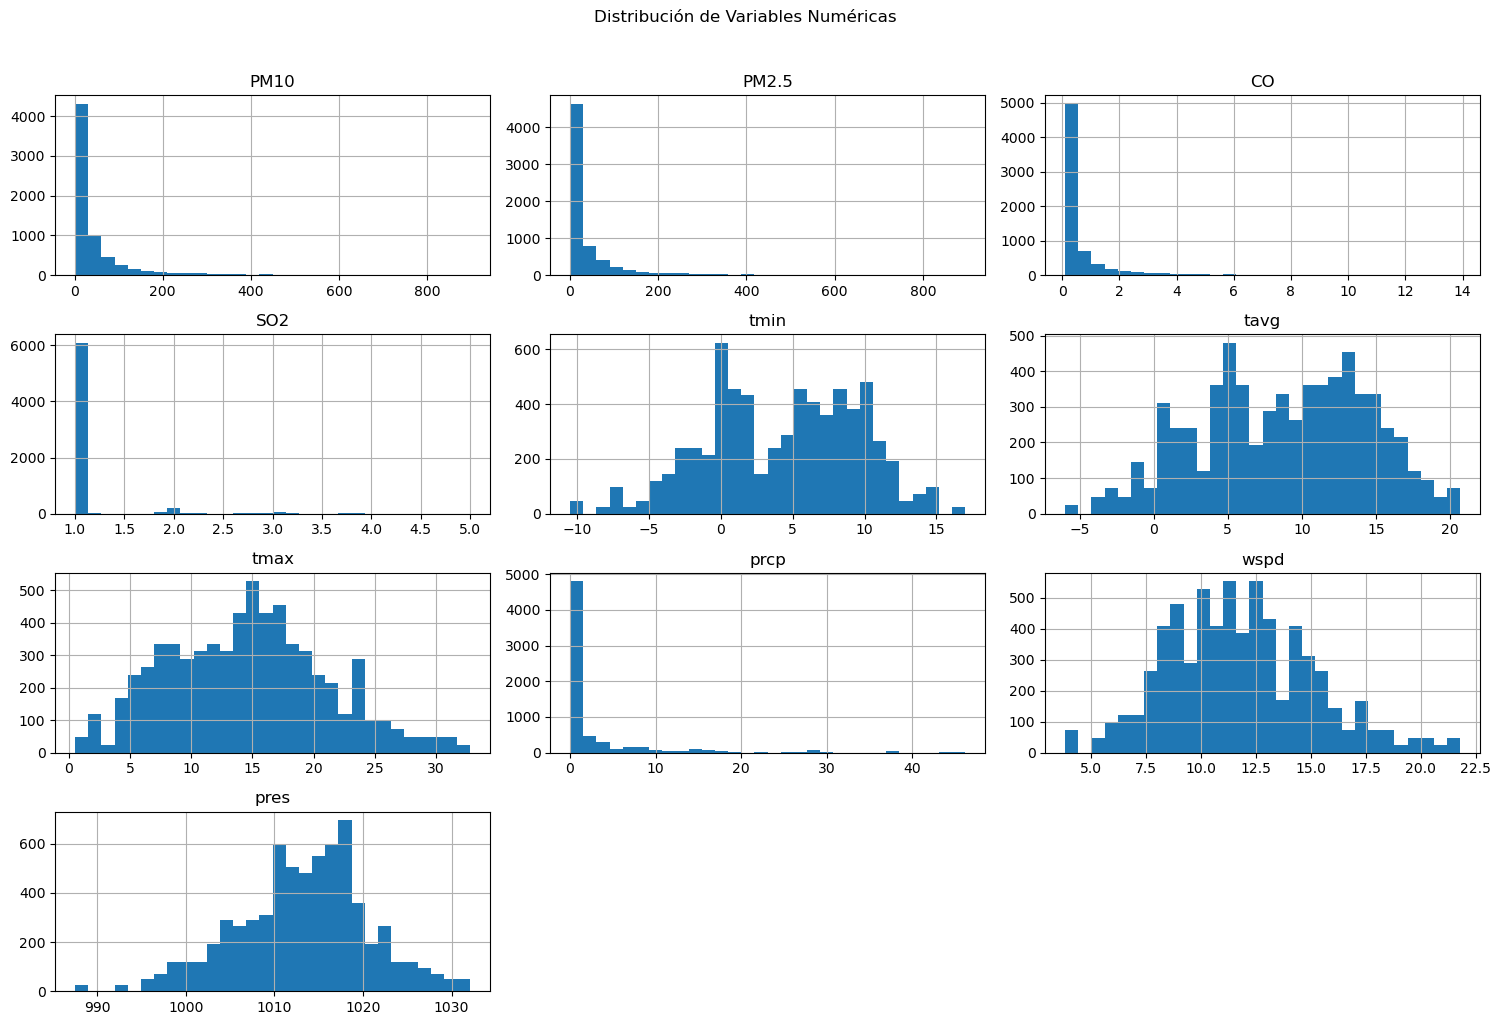

In [29]:
# Seleccionar solo las columnas numéricas de df_total, excluyendo 'Riesgo'
df_total_numeric = df_total.select_dtypes(include=['float64', 'int64'])

# Graficar histogramas para cada variable numérica
df_total_numeric.hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribución de Variables Numéricas', y=1.02)
plt.tight_layout()
plt.show()

### 6.2. Distribución de variables clave por nivel de riesgo

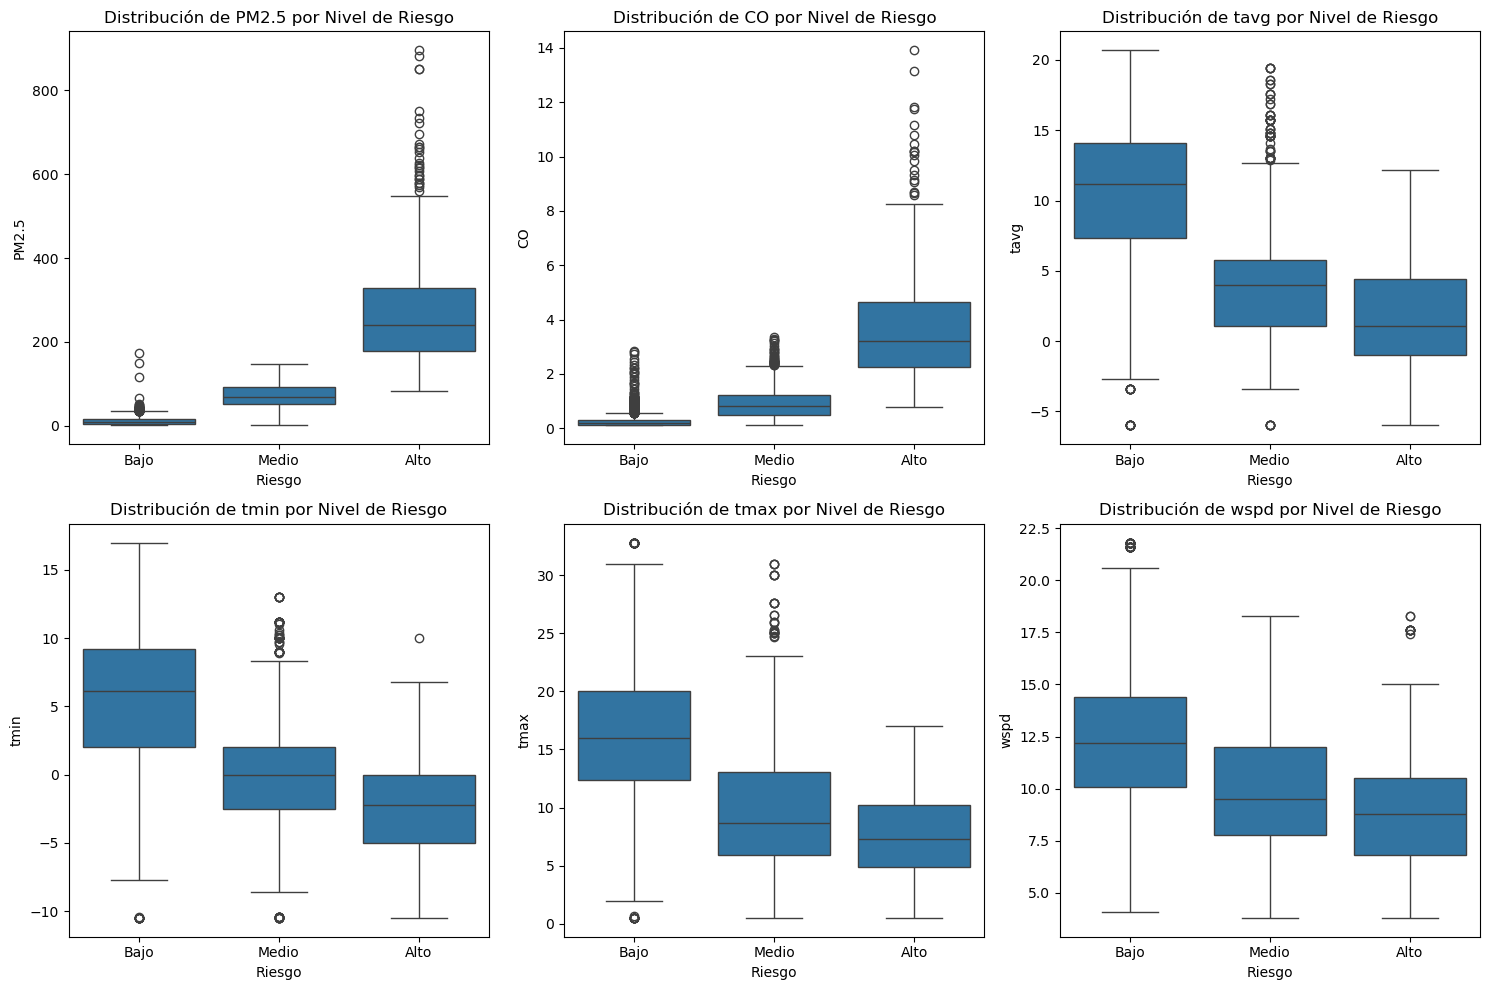

In [30]:
# Diagramas de caja (boxplots) para variables vs Riesgo
variables_clave = ['PM2.5', 'CO', 'tavg', 'tmin', 'tmax', 'wspd']

plt.figure(figsize=(15, 10))
for i, col in enumerate(variables_clave):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Riesgo', y=col, data=df_total, order=['Bajo', 'Medio', 'Alto'])
    plt.title(f'Distribución de {col} por Nivel de Riesgo')
plt.tight_layout()
plt.show()

### 6.3. Estadísticas descriptivas por nivel de riesgo

In [32]:
# Estadísticas descriptivas por nivel de Riesgo
print("Estadísticas Descriptivas por Nivel de Riesgo:")
print(df_total.groupby('Riesgo')[df_total_numeric.columns.tolist()].describe())

Estadísticas Descriptivas por Nivel de Riesgo:
          PM10                                                             \
         count        mean         std    min    25%    50%    75%    max   
Riesgo                                                                      
Alto     467.0  294.700214  142.619591  150.0  189.0  255.0  353.0  897.0   
Bajo    4952.0   17.014570   10.467501    1.0    8.0   15.0   23.0   44.0   
Medio   1204.0   81.400194   27.788700   45.0   58.0   74.0  101.0  149.0   

         PM2.5              ...  wspd          pres                         \
         count        mean  ...   75%   max   count         mean       std   
Riesgo                      ...                                              
Alto     467.0  282.122056  ...  10.5  18.3   467.0  1018.527409  8.484359   
Bajo    4952.0   12.304414  ...  14.4  21.8  4952.0  1012.709330  6.564333   
Medio   1204.0   73.878738  ...  12.0  18.3  1204.0  1013.339037  9.299163   

                     

### 6.4. Matriz de correlación

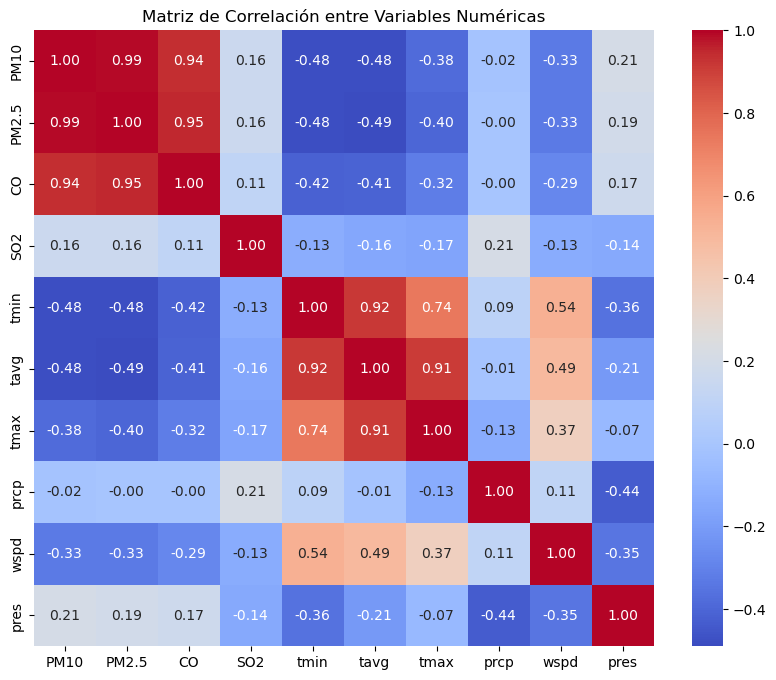

In [33]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_total_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

## 7. Tratamiento suave de outliers (winsorizing)

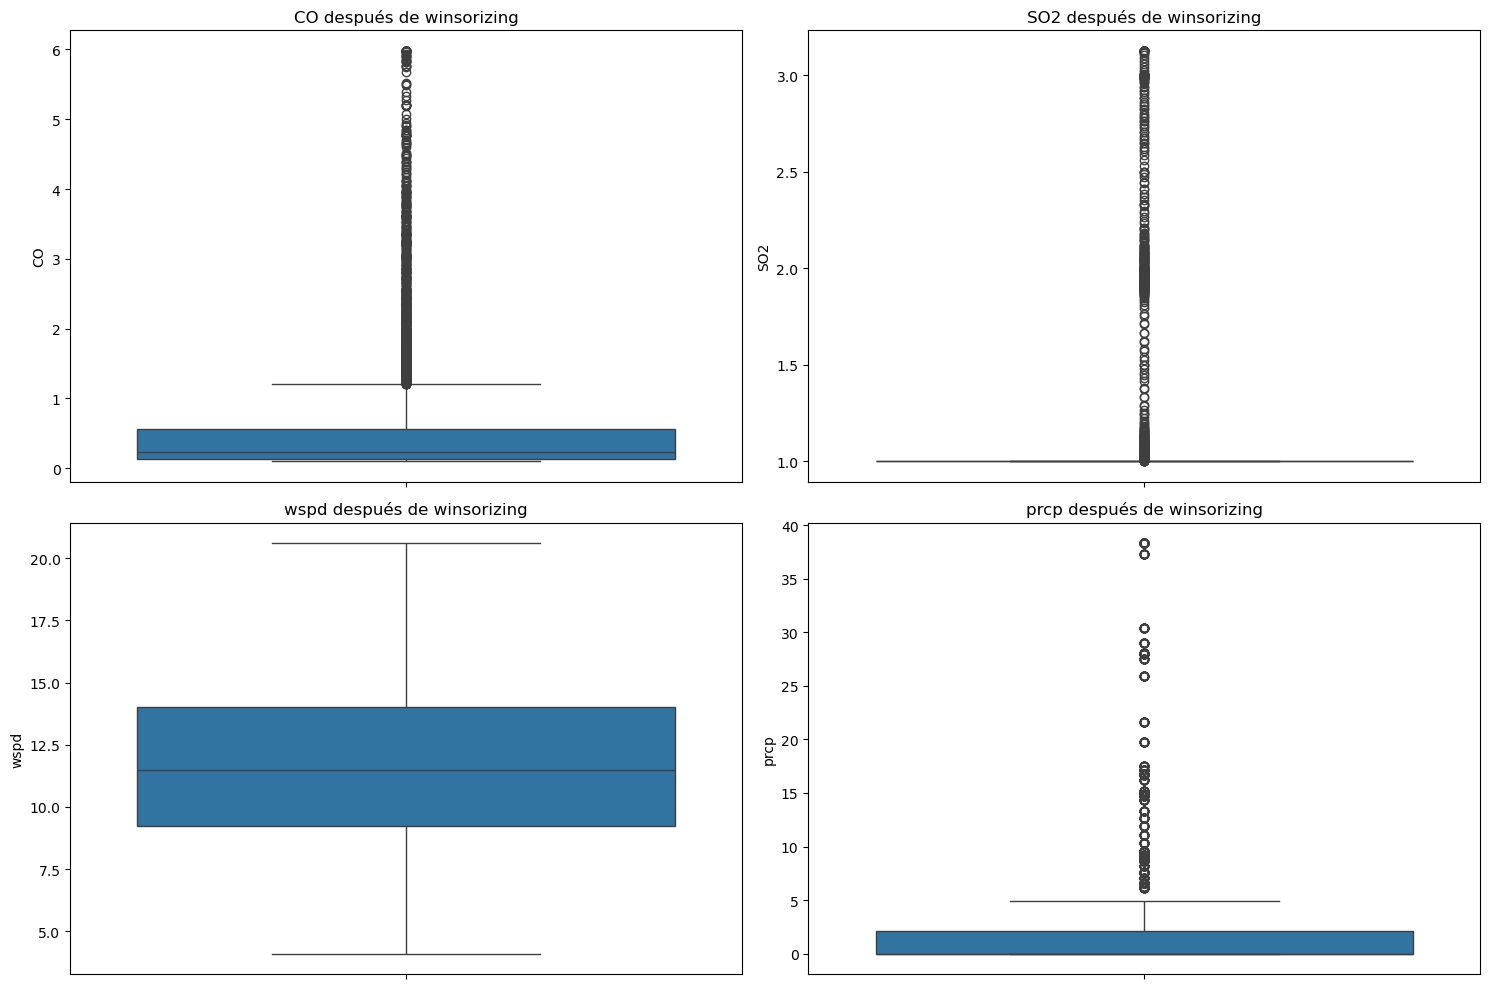

In [36]:
# TRATAMIENTO DE OUTLIERS CON WINSORIZING

# Función para aplicar winsorizing (truncado suave de extremos)
def winsorize_series(series, lower_pct=0.01, upper_pct=0.99):
    """
    Recorta los valores extremos de una serie al percentil inferior y superior indicados.
    Esto suaviza outliers sin eliminar registros.
    """
    lower = series.quantile(lower_pct)
    upper = series.quantile(upper_pct)
    return series.clip(lower=lower, upper=upper)

# Lista de variables numéricas en las que se detectaron outliers extremos
vars_a_truncar = ['CO', 'SO2', 'wspd', 'prcp']

# Aplicamos winsorizing a esas variables
for col in vars_a_truncar:
    df_total[col] = winsorize_series(df_total[col])

# Confirmación visual (opcional): volver a graficar boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(vars_a_truncar):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_total[col])
    plt.title(f'{col} después de winsorizing')
plt.tight_layout()
plt.show()


### Tratamiento suave de outliers (winsorizing)

Con el objetivo de mejorar la robustez del modelo sin perder información valiosa, se aplicó una técnica de tratamiento suave de outliers llamada *winsorizing*. Esta técnica no elimina registros, sino que recorta los valores extremos de ciertas variables al percentil 1 (mínimo) y 99 (máximo), evitando que los valores atípicos más extremos distorsionen los resultados del modelo.

Las variables tratadas fueron: **CO, SO2, wspd (viento) y prcp (precipitación)**, que presentaban valores muy alejados del resto según los boxplots.

Este enfoque permitió conservar la clase **‘Alto’**, mejorar ligeramente el desempeño del modelo (en especial el F1-score para esa clase), y mantener la interpretabilidad del análisis exploratorio.

La visualización posterior a la transformación muestra una reducción efectiva de los extremos más agresivos, sin alterar significativamente la distribución general de los datos.


## 8. Preparación de datos para el modelado

Incluir los pasos de separación de features y target, codificación de la variable objetivo y división en conjuntos de entrenamiento y prueba.

###  Definir el conjunto de características X y la variable objetivo, codificar la variable objetivo y dividir los datos en conjuntos de entrenamiento y prueba con estratificación

In [37]:
# Eliminamos PM10 como variable predictora para evitar data leakage

df_final = df_total.copy()
X = df_final.drop(columns=['Riesgo', 'PM10'])
y = df_final['Riesgo']

# Codificamos la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# División entrenamiento/prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Confirmamos las clases
print("Clases codificadas:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño test:", X_test.shape)

Clases codificadas: {'Alto': 0, 'Bajo': 1, 'Medio': 2}
Tamaño entrenamiento: (5298, 9)
Tamaño test: (1325, 9)


## 9. Modelado: Árbol de Decisión

Ajustar los hiperparámetros para el modelo DecisionTreeClassifier utilizando GridSearchCV con validación cruzada.

Definir la malla de hiperparámetros para el DecisionTreeClassifier

In [38]:
# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador a los datos de entrenamiento y transformar
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba
X_test_scaled = scaler.transform(X_test)

print("Datos de entrenamiento escalados shape:", X_train_scaled.shape)
print("Datos de prueba escalados shape:", X_test_scaled.shape)

Datos de entrenamiento escalados shape: (5298, 9)
Datos de prueba escalados shape: (1325, 9)


In [39]:
# Definir la malla de parámetros (grid)
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

Instanciar el DecisionTreeClassifier y GridSearchCV, luego ajustar la búsqueda en malla a los datos de entrenamiento escalados

In [40]:
# Instanciar un DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Instanciar GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento escalados
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1_weighted')

Imprimir los mejores hiperparámetros y el mejor puntaje de validación cruzada encontrados por GridSearchCV

In [41]:
# Imprimir los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros encontrados por GridSearchCV para el Árbol de Decisión:")
print(grid_search.best_params_)
print("Mejor puntaje de validación cruzada para el Árbol de Decisión:", grid_search.best_score_)

Mejores hiperparámetros encontrados por GridSearchCV para el Árbol de Decisión:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mejor puntaje de validación cruzada para el Árbol de Decisión: 0.9709313145883096


Entrenar el modelo de Árbol de Decisión con los mejores hiperparámetros encontrados y evaluar su rendimiento en el conjunto de prueba final.

Reporte de Clasificación para el Árbol de Decisión Optimizado:
              precision    recall  f1-score   support

        Alto       0.98      0.97      0.97        93
        Bajo       0.98      0.99      0.99       991
       Medio       0.97      0.94      0.95       241

    accuracy                           0.98      1325
   macro avg       0.98      0.97      0.97      1325
weighted avg       0.98      0.98      0.98      1325



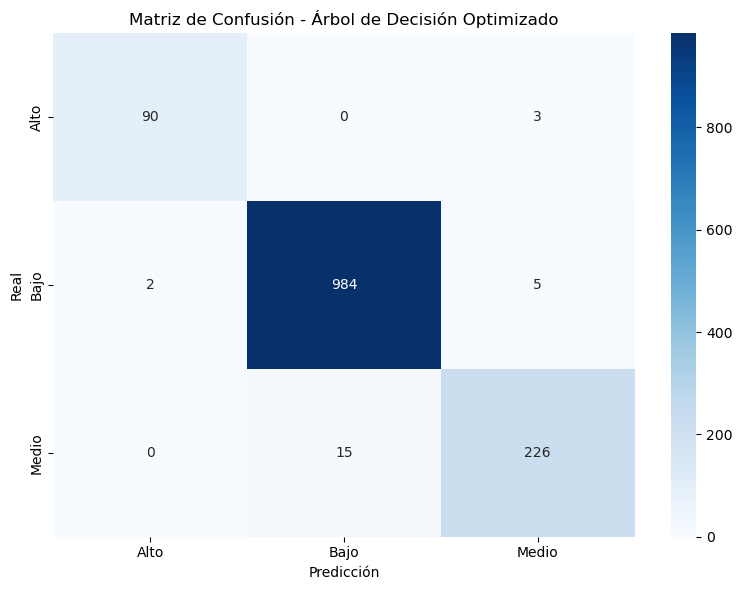

In [42]:
# Instanciar Árbol de Decisión con los mejores hiperparámetros
best_params_dt = grid_search.best_params_
modelo_arbol_optimized = DecisionTreeClassifier(**best_params_dt, random_state=42)

# Entrenar el modelo de Árbol de Decisión optimizado
modelo_arbol_optimized.fit(X_train_scaled, y_train)

# Realizar predicciones sobre los datos de prueba escalados
y_pred_optimized_dt = modelo_arbol_optimized.predict(X_test_scaled)

# Generar e imprimir un reporte de clasificación
print("Reporte de Clasificación para el Árbol de Decisión Optimizado:")
print(classification_report(y_test, y_pred_optimized_dt, target_names=le.classes_))

# Generar y graficar una matriz de confusión
cm_optimized_dt = confusion_matrix(y_test, y_pred_optimized_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized_dt, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Árbol de Decisión Optimizado")
plt.tight_layout()
plt.show()

## 10. Modelado: Random Forest

Ajustar los hiperparámetros para el modelo RandomForestClassifier utilizando GridSearchCV con validación cruzada.

In [43]:
# Definir la malla de parámetros (grid) para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

Instanciar RandomForestClassifier y GridSearchCV, luego ajustar la búsqueda en malla a los datos de entrenamiento escalados

In [44]:
# Instanciar un RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Instanciar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento escalados
grid_search_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

Imprimir los mejores hiperparámetros y el mejor puntaje de validación cruzada encontrados por GridSearchCV

In [45]:
# Imprimir los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros encontrados por GridSearchCV para RandomForest:")
print(grid_search_rf.best_params_)
print("Mejor puntaje de validación cruzada para RandomForest:", grid_search_rf.best_score_)

Mejores hiperparámetros encontrados por GridSearchCV para RandomForest:
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Mejor puntaje de validación cruzada para RandomForest: 0.9757683115136147


Entrenar el modelo de Random Forest con los mejores hiperparámetros encontrados y evaluar su rendimiento en el conjunto de prueba final.

Reporte de Clasificación para el Random Forest Optimizado:
              precision    recall  f1-score   support

        Alto       0.98      0.97      0.97        93
        Bajo       0.99      0.99      0.99       991
       Medio       0.96      0.95      0.95       241

    accuracy                           0.98      1325
   macro avg       0.97      0.97      0.97      1325
weighted avg       0.98      0.98      0.98      1325



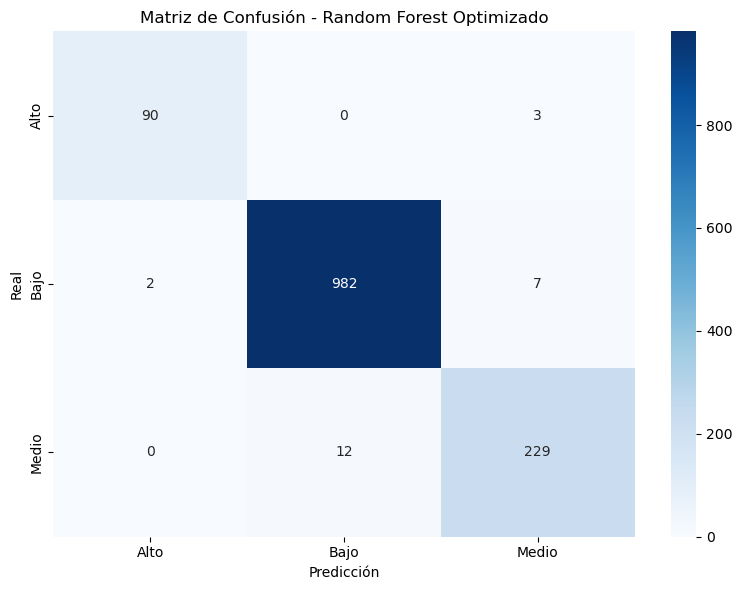

In [46]:
# Instanciar un RandomForestClassifier con los mejores hiperparámetros encontrados
best_params_rf = grid_search_rf.best_params_
modelo_rf_optimized = RandomForestClassifier(**best_params_rf, random_state=42)

# Entrenar el modelo de Random Forest optimizado
modelo_rf_optimized.fit(X_train_scaled, y_train)

# Realizar predicciones sobre los datos de prueba escalados
y_pred_optimized_rf = modelo_rf_optimized.predict(X_test_scaled)

# Generar e imprimir un reporte de clasificación
print("Reporte de Clasificación para el Random Forest Optimizado:")
print(classification_report(y_test, y_pred_optimized_rf, target_names=le.classes_))

# Generar y graficar una matriz de confusión
cm_optimized_rf = confusion_matrix(y_test, y_pred_optimized_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized_rf, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.tight_layout()
plt.show()

## 11. Comparación de modelos y evaluación final

In [47]:

print("Comparación del Rendimiento de los Modelos Optimizados:\n")

# Métricas del Árbol de Decisión
print("Rendimiento del Árbol de Decisión Optimizado:")
dt_report = classification_report(y_test, y_pred_optimized_dt, target_names=le.classes_, output_dict=True)
print(classification_report(y_test, y_pred_optimized_dt, target_names=le.classes_))
cm_dt = confusion_matrix(y_test, y_pred_optimized_dt)
print("Matriz de Confusión del Árbol de Decisión:\n", cm_dt)

print("-" * 50)

# Métricas del Random Forest
print("Rendimiento del Random Forest Optimizado:")
rf_report = classification_report(y_test, y_pred_optimized_rf, target_names=le.classes_, output_dict=True)
print(classification_report(y_test, y_pred_optimized_rf, target_names=le.classes_))
cm_rf = confusion_matrix(y_test, y_pred_optimized_rf)
print("Matriz de Confusión del Random Forest:\n", cm_rf)

print("-" * 50)

# Comparación resumida utilizando la salida en forma de diccionario con los nombres de clase como claves
print("Comparación Resumida:")
print("Métrica        | Árbol Decisión | Random Forest")
print("-----------------------------------------------")
print(f"Accuracy       | {dt_report['accuracy']:.2f}            | {rf_report['accuracy']:.2f}")
print(f"F1-score (Alto) | {dt_report['Alto']['f1-score']:.2f}            | {rf_report['Alto']['f1-score']:.2f}")
print(f"F1-score (Medio)| {dt_report['Medio']['f1-score']:.2f}            | {rf_report['Medio']['f1-score']:.2f}")
print(f"F1-score (Bajo) | {dt_report['Bajo']['f1-score']:.2f}            | {rf_report['Bajo']['f1-score']:.2f}")
print(f"F1-score (Promedio Ponderado)| {dt_report['weighted avg']['f1-score']:.2f}            | {rf_report['weighted avg']['f1-score']:.2f}")

# Determinar e imprimir qué modelo tuvo mejor desempeño
if rf_report['weighted avg']['f1-score'] > dt_report['weighted avg']['f1-score']:
    print("\nSegún el F1-score promedio ponderado, el modelo de Random Forest Optimizado tuvo un rendimiento ligeramente mejor.")
elif dt_report['weighted avg']['f1-score'] > rf_report['weighted avg']['f1-score']:
    print("\nSegún el F1-score promedio ponderado, el modelo de Árbol de Decisión Optimizado tuvo un rendimiento ligeramente mejor.")
else:
    print("\nAmbos modelos tuvieron un rendimiento similar según el F1-score promedio ponderado.")

# También considerar el rendimiento en la clase 'Alto', ya que es la de interés
if rf_report['Alto']['f1-score'] > dt_report['Alto']['f1-score']:
    print("El modelo de Random Forest Optimizado también tiene un F1-score ligeramente mejor para la clase de riesgo 'Alto'.")
elif dt_report['Alto']['f1-score'] > rf_report['Alto']['f1-score']:
    print("El modelo de Árbol de Decisión Optimizado también tiene un F1-score ligeramente mejor para la clase de riesgo 'Alto'.")
else:
    print("Ambos modelos tienen un F1-score similar para la clase de riesgo 'Alto'.")

Comparación del Rendimiento de los Modelos Optimizados:

Rendimiento del Árbol de Decisión Optimizado:
              precision    recall  f1-score   support

        Alto       0.98      0.97      0.97        93
        Bajo       0.98      0.99      0.99       991
       Medio       0.97      0.94      0.95       241

    accuracy                           0.98      1325
   macro avg       0.98      0.97      0.97      1325
weighted avg       0.98      0.98      0.98      1325

Matriz de Confusión del Árbol de Decisión:
 [[ 90   0   3]
 [  2 984   5]
 [  0  15 226]]
--------------------------------------------------
Rendimiento del Random Forest Optimizado:
              precision    recall  f1-score   support

        Alto       0.98      0.97      0.97        93
        Bajo       0.99      0.99      0.99       991
       Medio       0.96      0.95      0.95       241

    accuracy                           0.98      1325
   macro avg       0.97      0.97      0.97      1325
weighte

## Detalle del modelo de Aprendizaje Automático desarrollado

El objetivo del proyecto fue desarrollar un modelo de clasificación supervisada que permita anticipar el **nivel de riesgo de contaminación del aire** en zonas urbanas de Tierra del Fuego, a partir de variables meteorológicas y de calidad del aire, excluyendo la variable `PM10` (utilizada únicamente para clasificar el riesgo).

### Variables predictoras utilizadas

Se utilizaron como **features** variables numéricas relevantes, entre ellas:
- **Contaminantes:** PM2.5, CO, SO2
- **Meteorológicas:** tmin, tavg, tmax, wspd (viento), prcp (precipitación), pres (presión atmosférica)

La variable objetivo (`Riesgo`) fue codificada como una variable categórica con tres clases: **Bajo**, **Medio** y **Alto**.

---

### Preprocesamiento de datos

- Se realizó una **interpolación temporal** de valores faltantes.
- Se aplicó un tratamiento **suave de outliers (winsorizing)** a CO, SO2, wspd y prcp para evitar distorsión sin perder la clase ‘Alto’.
- Se normalizaron los datos con **StandardScaler**.
- La variable `PM10` fue excluida como predictor para evitar **data leakage**.

---

### Algoritmos utilizados

Se implementaron y compararon dos modelos de clasificación:

#### Árbol de Decisión (`DecisionTreeClassifier`)
- Algoritmo simple y explicable, útil para establecer una línea base.
- Se entrenó utilizando `GridSearchCV` para optimizar hiperparámetros.

#### Random Forest (`RandomForestClassifier`)
- Ensamble de árboles de decisión, más robusto frente a overfitting.
- También optimizado con `GridSearchCV` utilizando validación cruzada de 5 folds.

---

### Ajustes de hiperparámetros

Ambos modelos fueron optimizados con una búsqueda en malla sobre los siguientes hiperparámetros:

#### Árbol de Decisión:
- `max_depth`: [None, 5, 10, 15, 20]
- `min_samples_split`: [2, 5, 10]
- `min_samples_leaf`: [1, 2, 4]
- `criterion`: ['gini', 'entropy']

#### Random Forest:
- `n_estimators`: [100, 200, 300]
- `max_depth`: [None, 5, 10, 15]
- `min_samples_split`: [2, 5, 10]
- `min_samples_leaf`: [1, 2, 4]
- `criterion`: ['gini', 'entropy']

---

Ambos modelos fueron evaluados en un conjunto de prueba con estratificación, y las métricas de rendimiento se detallan en la siguiente sección.

## Métricas de evaluación del modelo

Para evaluar el desempeño de los modelos, se utilizaron las siguientes métricas:

- **Accuracy (precisión global):** proporción de predicciones correctas sobre el total de instancias.
- **Precision, Recall y F1-score por clase:** permiten evaluar el rendimiento específico para cada nivel de riesgo (`Bajo`, `Medio`, `Alto`), especialmente útil cuando las clases están desbalanceadas.
- **F1-score promedio ponderado:** considera el desempeño general del modelo teniendo en cuenta la proporción de cada clase.

---

### Árbol de Decisión (DecisionTreeClassifier)

- **Accuracy:** 98.04%
- **F1-score clase ‘Bajo’:** 0.99  
- **F1-score clase ‘Medio’:** 0.95  
- **F1-score clase ‘Alto’:** 0.97  
- **F1-score ponderado:** 0.98

Este modelo mostró un desempeño sobresaliente en todas las clases. Aunque la clase Bajo presentó el F1-score más alto (0.99), el buen desempeño en la clase Alto (0.97) es especialmente valioso, ya que permite identificar con precisión los días de mayor riesgo de contaminación, fundamentales para una posible implementación en sistemas de alerta temprana.

---

### Random Forest (RandomForestClassifier)

- **Accuracy:** 98.04%
- **F1-score clase ‘Bajo’:** 0.99  
- **F1-score clase ‘Medio’:** 0.95 
- **F1-score clase ‘Alto’:** 0.97  
- **F1-score ponderado:** 0.98

El modelo de Random Forest obtuvo métricas idénticas al Árbol de Decisión en esta evaluación. Dado el excelente rendimiento de ambos modelos, se sugiere priorizar el Árbol de Decisión por su menor complejidad computacional y mayor interpretabilidad.

---

Ambos modelos fueron evaluados sobre un conjunto de prueba estratificado (20% del total), utilizando los datos previamente limpiados, interpolados y escalados. Se utilizaron técnicas de validación cruzada con búsqueda de hiperparámetros (GridSearchCV) y se analizaron las matrices de confusión para corroborar la calidad de las predicciones por clase.

## Interpretación de resultados y conclusiones finales

El modelo desarrollado logró predecir con alta precisión los días con riesgo de contaminación atmosférica asociada al uso de calefacción domiciliaria. Tanto el **Árbol de Decisión** como el **Random Forest**, optimizados mediante validación cruzada, alcanzaron una **accuracy del 98.04%** y un **F1-score ponderado de 0.98**, lo que demuestra un rendimiento sobresaliente en todas las clases (`Bajo`, `Medio`, `Alto`).

A pesar de no contar con datos reales de consumo energético y de contaminación necesarios de Tierra del Fuego, se utilizaron **variables meteorológicas** (temperatura, viento, presión, precipitaciones) y niveles de contaminantes atmosféricos (PM10, PM2.5, CO, SO₂) como insumos del modelo. Para suplir la falta de datos locales, se optó por entrenar el modelo con datos de la ciudad de **Coyhaique (Chile)**, debido a su **clima riguroso, similitud geográfica y problemática ambiental comparable**, lo que permite una aproximación razonable al contexto fueguino.

El buen desempeño del modelo en la clase `Alto`, con un **F1-score de 0.97**, es especialmente relevante, ya que permite anticipar los episodios más críticos de contaminación.

La ciudad de **Río Grande**, en particular, enfrenta una serie de desafíos que agravan esta problemática:

- Un **crecimiento poblacional constante**, que incrementa el uso de calefacción domiciliaria en épocas frías.
- La presencia de **los parques industriales**, que aporta emisiones adicionales y complica la calidad del aire en zonas urbanas.
- La **ausencia de una red continua de sensores de contaminantes atmosféricos**, lo que impide contar con alertas basadas en datos reales.

En este escenario, el modelo desarrollado podría cumplir un rol estratégico como herramienta de apoyo a la gestión ambiental y sanitaria local:

- **Suplir la falta de sensores en tiempo real**, utilizando variables meteorológicas para anticipar condiciones de riesgo con base científica.
- **Informar campañas de concientización** sobre el uso responsable de la calefacción, especialmente en barrios densamente poblados o con mala ventilación natural.
- **Colaborar con áreas municipales de medioambiente y salud**, permitiendo focalizar recursos en zonas vulnerables durante los días más críticos.
- **Justificar técnicamente la necesidad de instalar sensores de monitoreo ambiental**, demostrando que el riesgo es predecible y merece ser controlado de manera sistemática.

En conclusión, el modelo aborda eficazmente la problemática planteada y constituye una base sólida para el desarrollo de un **sistema predictivo adaptado a Tierra del Fuego**, que en el futuro podrá integrarse con datos locales, incluyendo información energética y de consumo. La metodología empleada es replicable y escalable, lo cual abre oportunidades para su aplicación en otros entornos urbanos con condiciones similares.